# Queue Estimation on LLMs

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import re

In [2]:
data_dir = "data_05Dec"

In [3]:
def get_lam(C, w):
    """compute lambda in requests per second"""
    return float(C*1_000_000/w)
    
def get_fname_frag_for_exp(MB, C, w, t, n, d):
    """make name fragment for the CSV files of that experiment"""
    return f'MB_{MB}_C{C}_w{w}_t{t}_n{n}_d{d}'

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def load_dfs(MB, C, w, t, n, d):
    exp_str = get_fname_frag_for_exp(MB, C, w, t, n, d)
    
    if C > 1:
        r_fnames = [f'{data_dir}/round_trips_{exp_str}_{i}.csv' for i in range(1, C+1)]
        print(f'Reading from {r_fnames}')        
        r_dfs = [pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok']) for r_fname in r_fnames]
        r_df = pd.concat(r_dfs, ignore_index=True)
    else:
        r_fname = f'{data_dir}/round_trips_{exp_str}.csv'
        print(f'Reading from {r_fname}')
        r_df = pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok'])
    r_df['start'] = pd.to_datetime(r_df['start'], unit="s")
    r_df['end'] = pd.to_datetime(r_df['end'], unit="s")
    first, last = r_df['start'].min(), r_df['start'].max() 
    interval = last - first
    start, end = first + 0.1 * interval, first + 0.9 * interval
    raw_r_df = pd.DataFrame(r_df)
    r_df = r_df.loc[(r_df['start'] >= start) & (r_df['start'] <= end)]

    q_fname = f'{data_dir}/queue_size_{exp_str}.csv'
    print(f'Reading from {q_fname}')
    q_df = pd.read_csv(q_fname, parse_dates=['timestamp'])
    q_df = q_df.loc[(q_df['timestamp'] >= start) & (q_df['timestamp'] <= end)]
    
    q_df.index = q_df['timestamp'] # normalize(q_df['timestamp'].astype(int))
    q_df['in_service'] = q_df.queue_size + q_df.batch_current_size
    return exp_str, q_df, r_df, raw_r_df

def extract_cq_df(r_df, start, end):
    starts = r_df.start.sort_values()
    ends = r_df.end.sort_values()
    cq = []
    for t in starts:
        cq.append([t, 1])
    for t in ends:
        cq.append([t, -1])
    cq = sorted(cq, key=lambda r: r[0])
    cq_df = pd.DataFrame(data=cq, columns=['time', 'd'])
    cq_df['q'] = cq_df['d'].cumsum()
    cq_df = cq_df.loc[(cq_df['time'] >= start) & (cq_df['time'] <= end)]
    cq_df.index = cq_df['time'] #normalize(cq_df['time'])
    return cq_df

def title_from_exp_str(frag):
    # Replace underscores with spaces
    s = frag.replace('_', ' ')
    
    # Insert '=' between letters and numbers
    s = re.sub(r'([a-zA-Z])(\d+)', r'\1=\2', s)
    
    # Add commas to large numbers (1,000 and above)
    s = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', s)
    return s


In [4]:
def plot_queues(q_df, cq_df, exp_str):
    mean_in_service = q_df['in_service'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['in_service'], label='In System')
    plt.plot(q_df.index, q_df['batch_current_size'], label='Current Batch')
    plt.plot(cq_df.index, cq_df['q'], label='From client side')
    plt.axhline(y=mean_in_service, color='green', linestyle='--', label=f'Mean ({mean_in_service:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Requests in Service')
    plt.title(title_from_exp_str(exp_str))
    ax = plt.gca()
    ax.set_ylim(0, int(q_df['in_service'].max()) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=8))

    plt.legend()
    plt.tight_layout()

def plot_input_rate(q_df, lam, exp_str):
    mean_request_rate = q_df['request_rate'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['request_rate'], label=r'Observed Requests Rate $\lambda$')
    plt.axhline(y=mean_request_rate, color='green', linestyle='--', label=f'Mean ({mean_request_rate:.2f})')
    plt.axhline(y=lam, color='orange', linestyle=':', label=f'True value ({lam:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel(r'Observed Request Rate $\lambda$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()

def plot_estimated_mu(mu_hat, r_df, exp_str):
    mean_mu_hat = mu_hat.mean()
    rtt_mean = r_df['rtt'].mean()
    per_req_mean = 1 / rtt_mean
    plt.figure(figsize=(10, 6))
    plt.plot(mu_hat, label=r'Estimated Service Rate $\hat{\mu}$')
    plt.axhline(y=mean_mu_hat, color='green', linestyle='--', label=f'Mean ({mean_mu_hat:.2f})')
    # plt.axhline(y=per_req_mean, color='orange', linestyle=':', label=f'Client Observed ({per_req_mean:.2f})')
    plt.ylim((0,None))
    plt.xlabel('Timestamp')
    plt.ylabel(r'Estimated Service Rate $\hat{\mu}$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()


In [5]:
def estimate_mu(q_df, lam, d, MB):
    mu_hat = -1/d * q_df['in_service'].diff() + lam
    mu_hat = 1/MB * mu_hat.dropna()
    return mu_hat

# MB=1 $\lambda=4.0$

In [6]:
MB=1
C=4
w=1_000_000
t=200
n=240
d=2

In [7]:
lam = get_lam(C, w)

In [8]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_05Dec/round_trips_MB_1_C4_w1000000_t200_n240_d2_1.csv', 'data_05Dec/round_trips_MB_1_C4_w1000000_t200_n240_d2_2.csv', 'data_05Dec/round_trips_MB_1_C4_w1000000_t200_n240_d2_3.csv', 'data_05Dec/round_trips_MB_1_C4_w1000000_t200_n240_d2_4.csv']
Reading from data_05Dec/queue_size_MB_1_C4_w1000000_t200_n240_d2.csv


In [9]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-05 13:47:01.041,2024-12-05 13:47:01.041,70.0,1.0,6.0,71.0
2024-12-05 13:47:03.049,2024-12-05 13:47:03.049,81.0,1.0,4.0,82.0
2024-12-05 13:47:05.057,2024-12-05 13:47:05.057,83.0,1.0,4.0,84.0
2024-12-05 13:47:07.064,2024-12-05 13:47:07.064,94.0,1.0,4.0,95.0
2024-12-05 13:47:09.072,2024-12-05 13:47:09.072,104.0,1.0,6.0,105.0


In [10]:
r_df.head()

,i,start,end,rtt,ok
22,22,2024-12-05 13:47:00.407602310,2024-12-05 13:48:31.833790302,91.426188,0
23,23,2024-12-05 13:47:01.664834738,2024-12-05 13:48:37.222111702,95.557277,0
24,24,2024-12-05 13:47:02.187260866,2024-12-05 13:48:42.294455051,100.107194,0
25,25,2024-12-05 13:47:03.328034401,2024-12-05 13:48:47.175028324,103.846994,0
26,26,2024-12-05 13:47:04.826892376,2024-12-05 13:48:52.391472101,107.564579,0


In [11]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [12]:
cq_df.head()

,time,d,q
time,,,
2024-12-05 13:47:01.397463083,2024-12-05 13:47:01.397463083,-1,74
2024-12-05 13:47:01.659971237,2024-12-05 13:47:01.659971237,1,75
2024-12-05 13:47:01.664834738,2024-12-05 13:47:01.664834738,1,76
2024-12-05 13:47:01.665451288,2024-12-05 13:47:01.665451288,1,77
2024-12-05 13:47:01.667923212,2024-12-05 13:47:01.667923212,1,78


In [13]:
mu_hat = estimate_mu(q_df, lam, d, MB)

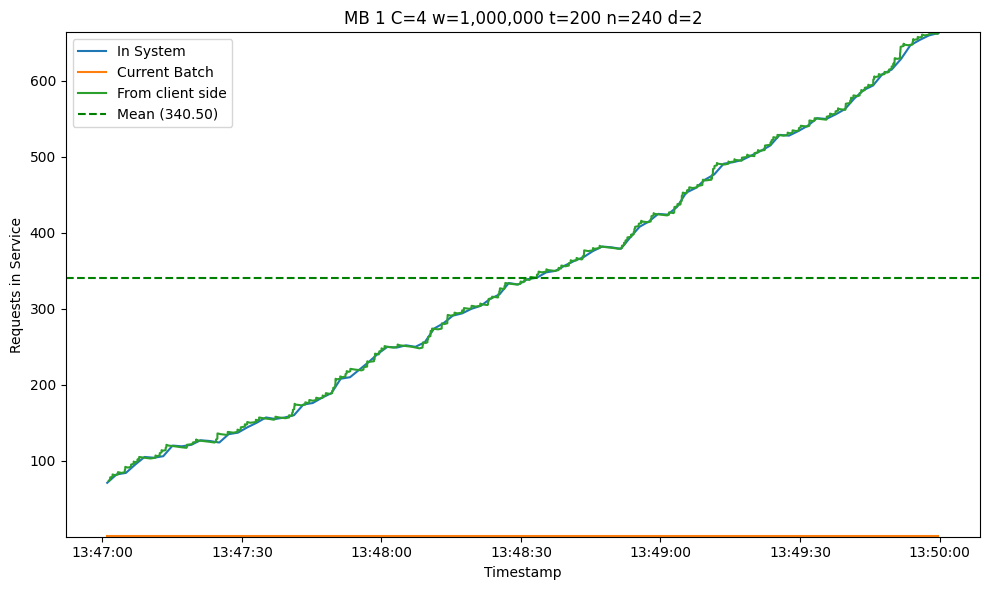

In [14]:
plot_queues(q_df, cq_df, exp_str)

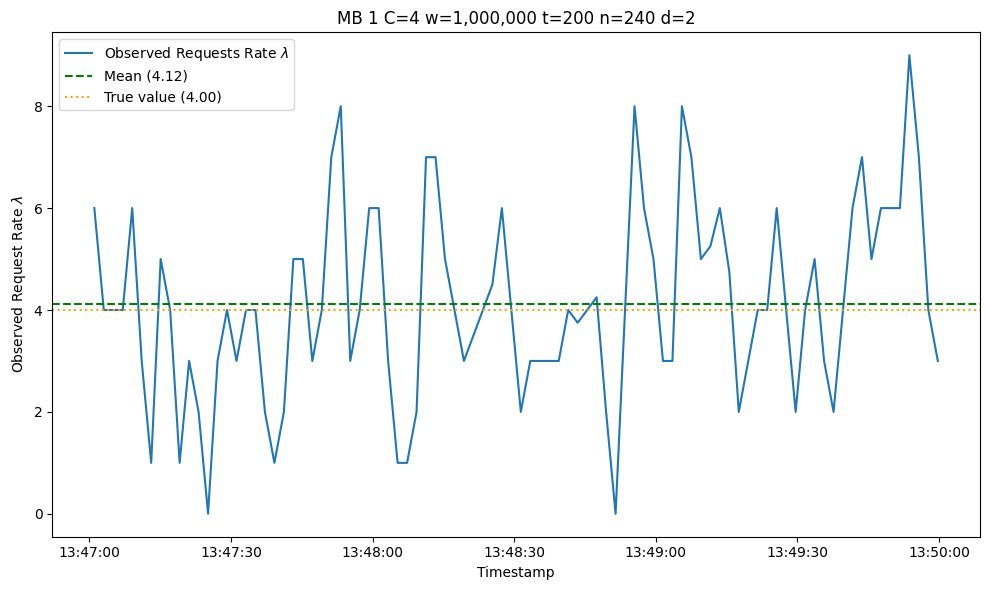

In [15]:
plot_input_rate(q_df, lam, exp_str)

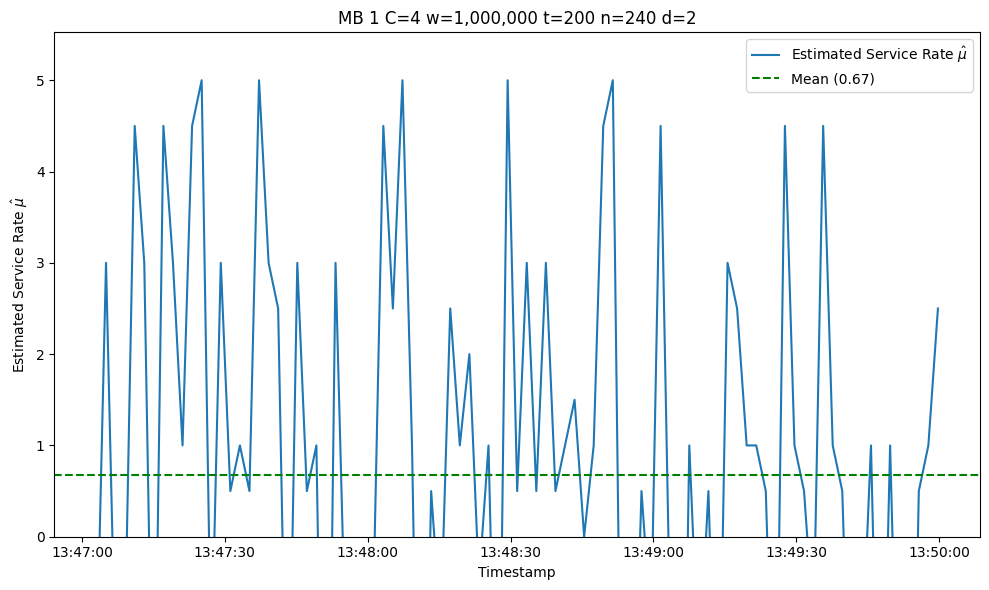

In [16]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=2 $\lambda=4.0$

In [17]:
MB=2
C=4
w=1_000_000
t=200
n=240
d=2

In [18]:
lam = get_lam(C, w)

In [19]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_05Dec/round_trips_MB_2_C4_w1000000_t200_n240_d2_1.csv', 'data_05Dec/round_trips_MB_2_C4_w1000000_t200_n240_d2_2.csv', 'data_05Dec/round_trips_MB_2_C4_w1000000_t200_n240_d2_3.csv', 'data_05Dec/round_trips_MB_2_C4_w1000000_t200_n240_d2_4.csv']
Reading from data_05Dec/queue_size_MB_2_C4_w1000000_t200_n240_d2.csv


In [20]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-05 14:08:22.660,2024-12-05 14:08:22.660,54.0,2.0,4.0,56.0
2024-12-05 14:08:24.668,2024-12-05 14:08:24.668,51.0,2.0,2.0,53.0
2024-12-05 14:08:26.676,2024-12-05 14:08:26.676,56.0,2.0,2.0,58.0
2024-12-05 14:08:28.685,2024-12-05 14:08:28.685,58.0,2.0,3.0,60.0
2024-12-05 14:08:30.696,2024-12-05 14:08:30.696,82.0,2.0,8.0,84.0


In [21]:
r_df.head()

,i,start,end,rtt,ok
21,21,2024-12-05 14:08:21.573408365,2024-12-05 14:08:55.261536360,33.688128,0
22,22,2024-12-05 14:08:21.940130234,2024-12-05 14:08:57.857463598,35.917333,0
23,23,2024-12-05 14:08:24.371840954,2024-12-05 14:09:00.891525507,36.519685,0
24,24,2024-12-05 14:08:25.152121067,2024-12-05 14:09:03.831490993,38.679370,0
25,25,2024-12-05 14:08:27.278197527,2024-12-05 14:09:06.420073509,39.141876,0


In [22]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [23]:
cq_df.head()

,time,d,q
time,,,
2024-12-05 14:08:23.308582306,2024-12-05 14:08:23.308582306,-1,54
2024-12-05 14:08:23.888492346,2024-12-05 14:08:23.888492346,-1,53
2024-12-05 14:08:24.371840954,2024-12-05 14:08:24.371840954,1,54
2024-12-05 14:08:24.372250795,2024-12-05 14:08:24.372250795,1,55
2024-12-05 14:08:24.376219511,2024-12-05 14:08:24.376219511,1,56


In [24]:
mu_hat = estimate_mu(q_df, lam, d, MB)

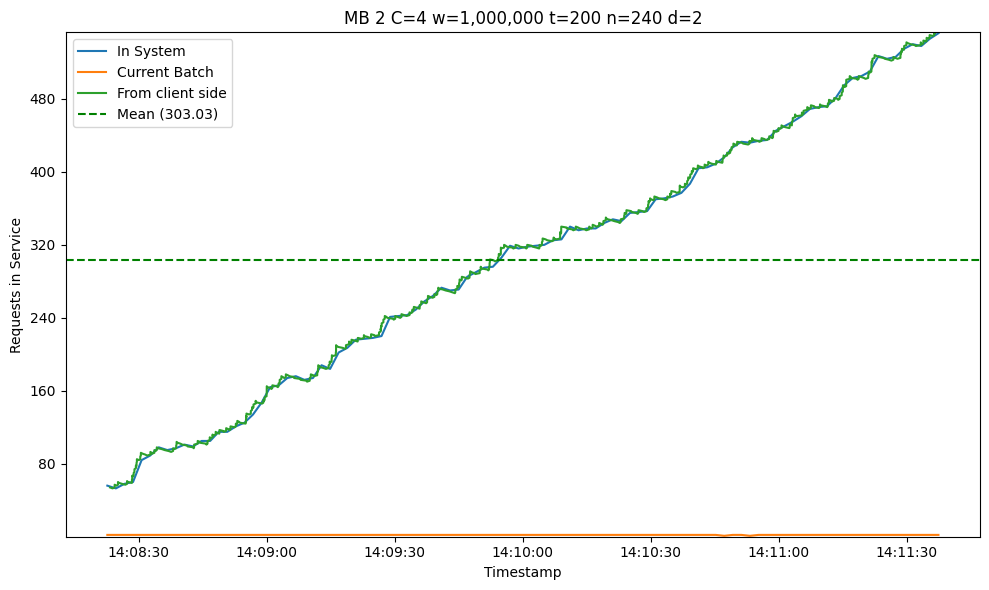

In [25]:
plot_queues(q_df, cq_df, exp_str)

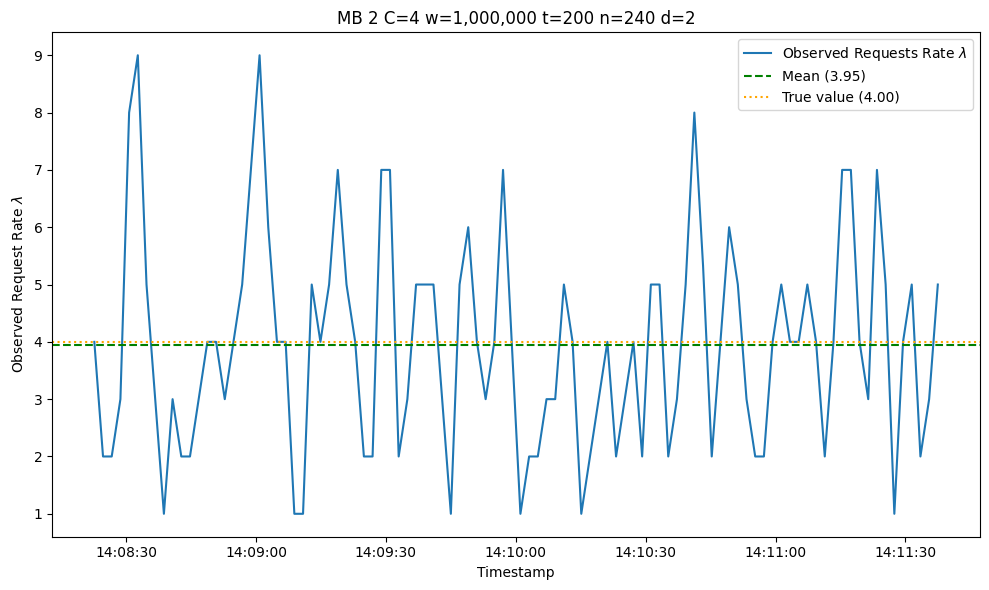

In [26]:
plot_input_rate(q_df, lam, exp_str)

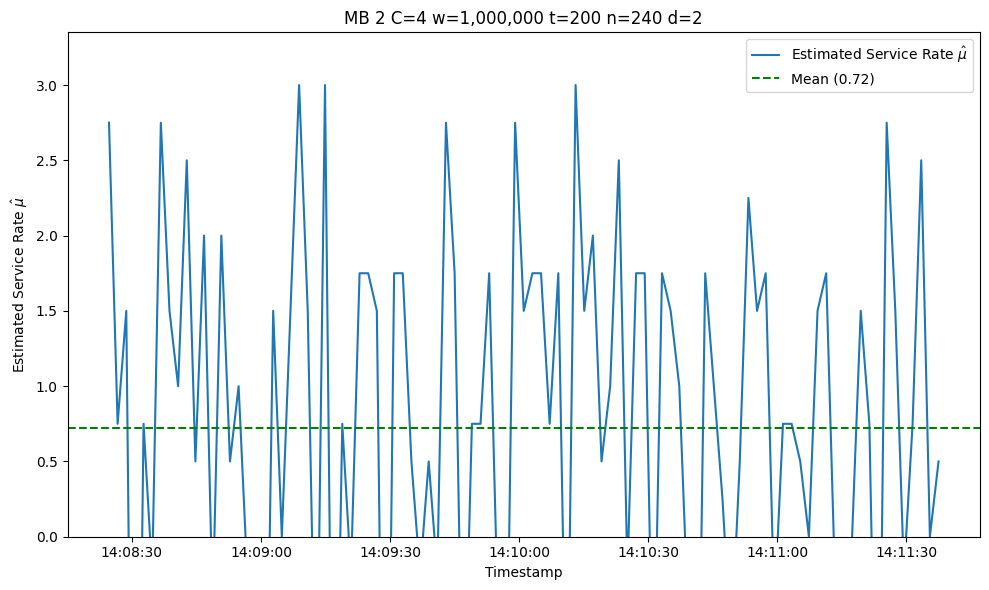

In [27]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=8 $\lambda=4.0$

In [28]:
MB=4
C=4
w=1_000_000
t=200
n=240
d=2

In [29]:
lam = get_lam(C, w)

In [30]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_05Dec/round_trips_MB_4_C4_w1000000_t200_n240_d2_1.csv', 'data_05Dec/round_trips_MB_4_C4_w1000000_t200_n240_d2_2.csv', 'data_05Dec/round_trips_MB_4_C4_w1000000_t200_n240_d2_3.csv', 'data_05Dec/round_trips_MB_4_C4_w1000000_t200_n240_d2_4.csv']
Reading from data_05Dec/queue_size_MB_4_C4_w1000000_t200_n240_d2.csv


In [31]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-05 14:20:40.175,2024-12-05 14:20:40.175,36.0,4.0,5.0,40.0
2024-12-05 14:20:42.188,2024-12-05 14:20:42.188,43.0,4.0,5.0,47.0
2024-12-05 14:20:44.197,2024-12-05 14:20:44.197,54.0,4.0,7.0,58.0
2024-12-05 14:20:46.205,2024-12-05 14:20:46.205,49.0,4.0,4.0,53.0
2024-12-05 14:20:48.213,2024-12-05 14:20:48.213,56.0,4.0,3.0,60.0


In [32]:
r_df.head()

,i,start,end,rtt,ok
23,23,2024-12-05 14:20:40.484186649,2024-12-05 14:20:55.301127672,14.816941,0
24,24,2024-12-05 14:20:40.748856306,2024-12-05 14:20:57.002241135,16.253385,0
25,25,2024-12-05 14:20:41.047845125,2024-12-05 14:20:58.726541042,17.678696,0
26,26,2024-12-05 14:20:41.619220495,2024-12-05 14:20:59.721040726,18.101820,0
27,27,2024-12-05 14:20:42.141036510,2024-12-05 14:21:01.526582718,19.385546,0


In [33]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [34]:
cq_df.head()

,time,d,q
time,,,
2024-12-05 14:20:40.247450829,2024-12-05 14:20:40.247450829,-1,37
2024-12-05 14:20:40.484186649,2024-12-05 14:20:40.484186649,1,38
2024-12-05 14:20:40.485550880,2024-12-05 14:20:40.485550880,1,39
2024-12-05 14:20:40.485805035,2024-12-05 14:20:40.485805035,1,40
2024-12-05 14:20:40.489391088,2024-12-05 14:20:40.489391088,1,41


In [35]:
mu_hat = estimate_mu(q_df, lam, d, MB)

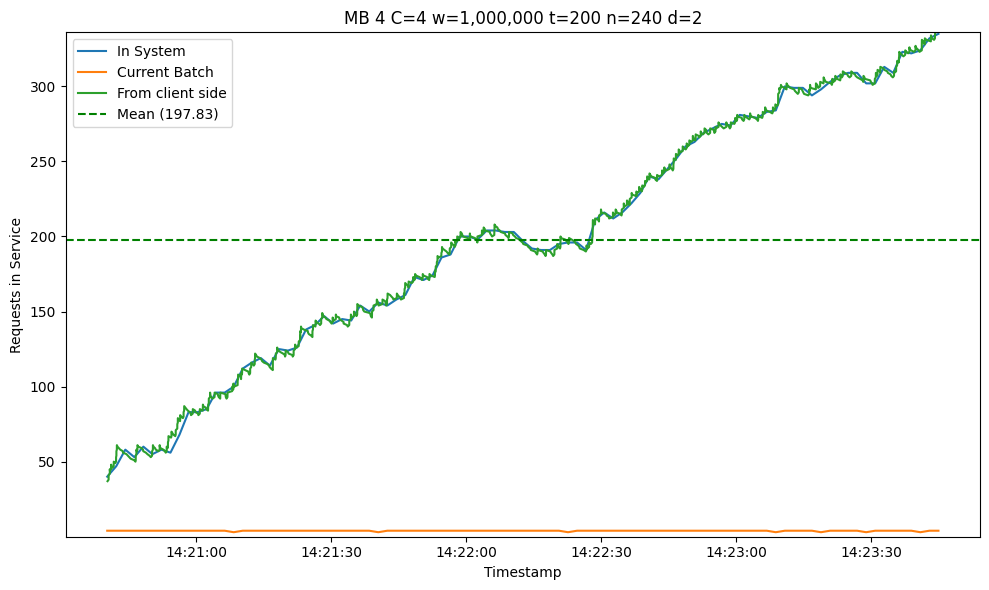

In [36]:
plot_queues(q_df, cq_df, exp_str)

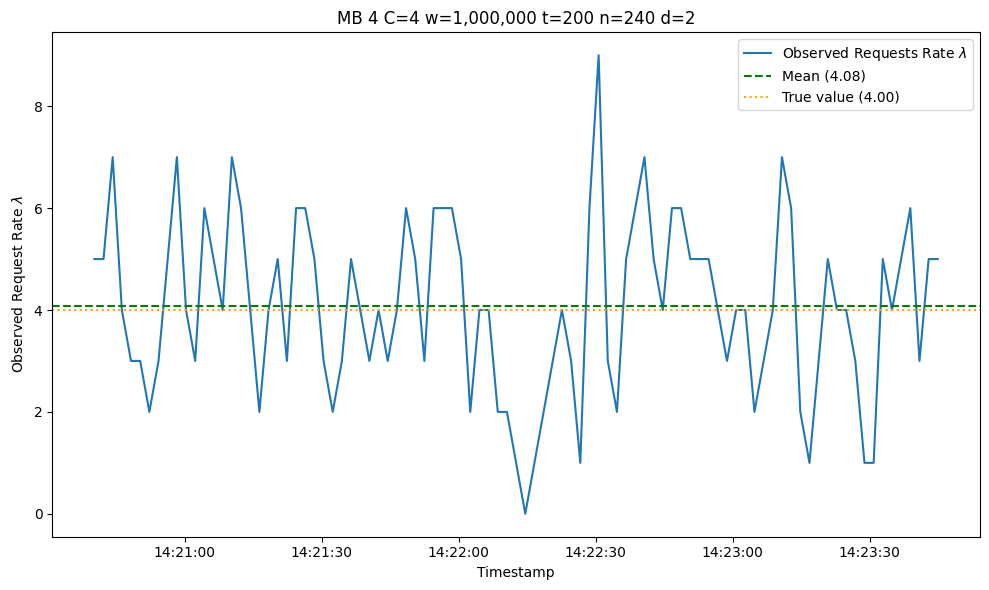

In [37]:
plot_input_rate(q_df, lam, exp_str)

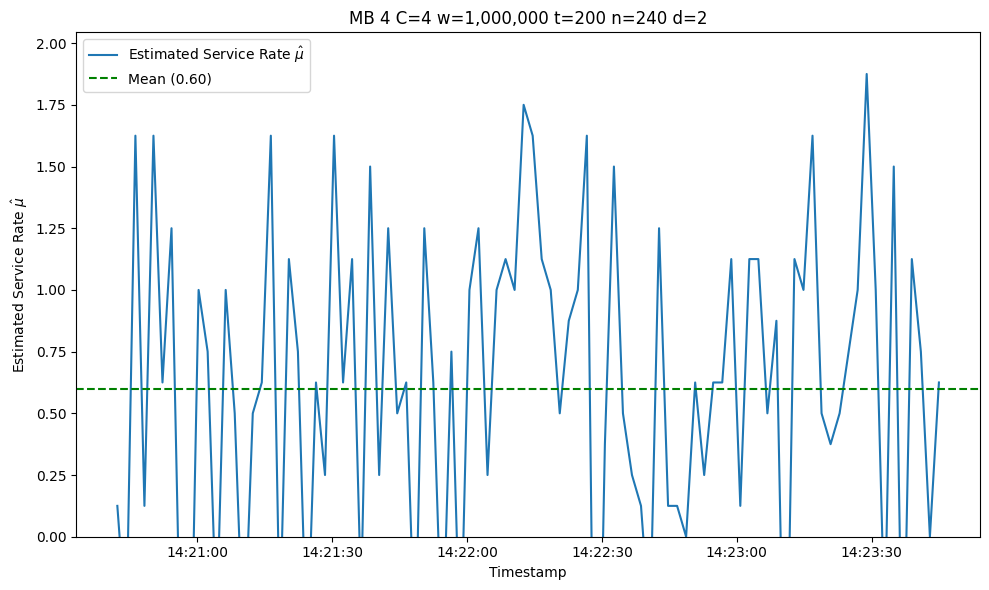

In [38]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=8 $\lambda=4.0$

In [39]:
MB=8
C=4
w=1_000_000
t=200
n=240
d=2

In [40]:
lam = get_lam(C, w)

In [41]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_05Dec/round_trips_MB_8_C4_w1000000_t200_n240_d2_1.csv', 'data_05Dec/round_trips_MB_8_C4_w1000000_t200_n240_d2_2.csv', 'data_05Dec/round_trips_MB_8_C4_w1000000_t200_n240_d2_3.csv', 'data_05Dec/round_trips_MB_8_C4_w1000000_t200_n240_d2_4.csv']
Reading from data_05Dec/queue_size_MB_8_C4_w1000000_t200_n240_d2.csv


In [42]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-05 14:28:04.835,2024-12-05 14:28:04.835,20.0,7.0,5.0,27.0
2024-12-05 14:28:06.843,2024-12-05 14:28:06.843,25.0,8.0,5.0,33.0
2024-12-05 14:28:08.852,2024-12-05 14:28:08.852,25.0,8.0,5.0,33.0
2024-12-05 14:28:10.860,2024-12-05 14:28:10.860,34.0,8.0,7.0,42.0
2024-12-05 14:28:12.868,2024-12-05 14:28:12.868,28.0,8.0,6.0,36.0


In [43]:
r_df.head()

,i,start,end,rtt,ok
28,28,2024-12-05 14:28:03.481395483,2024-12-05 14:28:10.683467627,7.202072,0
29,29,2024-12-05 14:28:04.510660172,2024-12-05 14:28:11.450926304,6.940266,0
30,30,2024-12-05 14:28:05.869344234,2024-12-05 14:28:12.201566458,6.332222,0
31,31,2024-12-05 14:28:05.995977640,2024-12-05 14:28:12.925349236,6.929372,0
32,32,2024-12-05 14:28:07.651482105,2024-12-05 14:28:13.919357777,6.267876,0


In [44]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [45]:
cq_df.head()

,time,d,q
time,,,
2024-12-05 14:28:05.165732861,2024-12-05 14:28:05.165732861,-1,29
2024-12-05 14:28:05.462683201,2024-12-05 14:28:05.462683201,-1,28
2024-12-05 14:28:05.462714195,2024-12-05 14:28:05.462714195,-1,27
2024-12-05 14:28:05.667717695,2024-12-05 14:28:05.667717695,-1,26
2024-12-05 14:28:05.863001823,2024-12-05 14:28:05.863001823,1,27


In [46]:
mu_hat = estimate_mu(q_df, lam, d, MB)

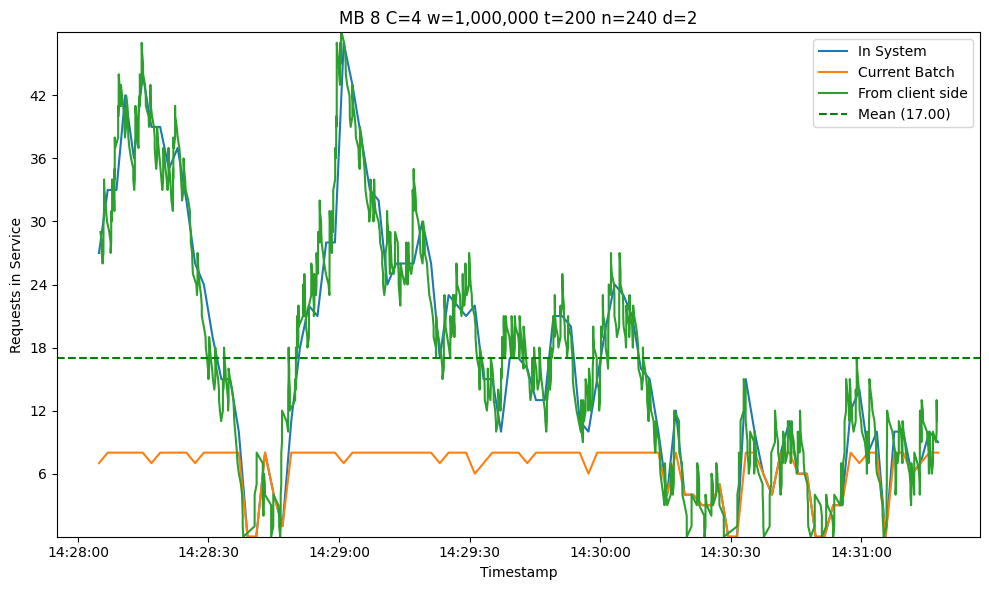

In [47]:
plot_queues(q_df, cq_df, exp_str)

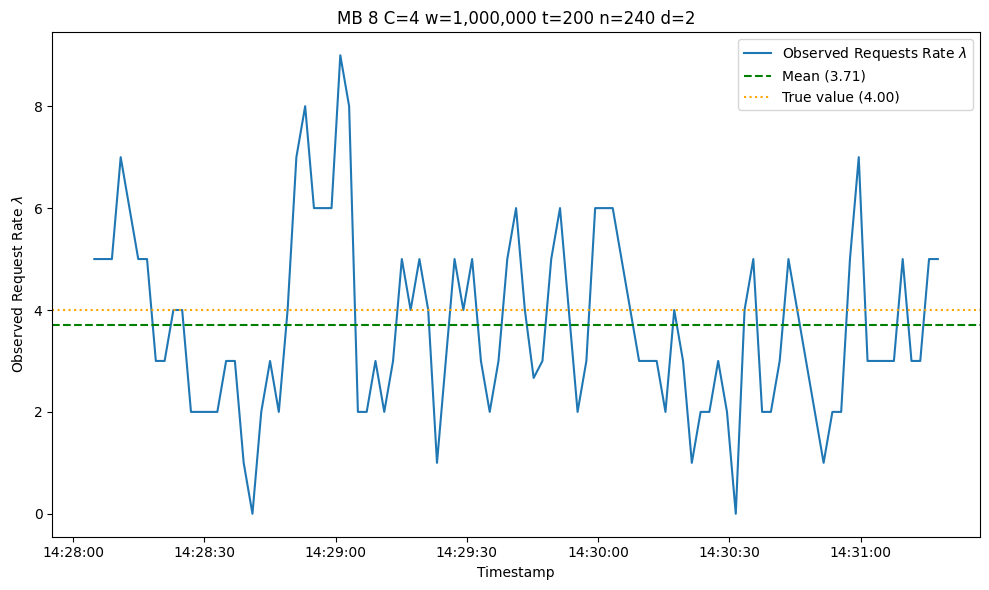

In [48]:
plot_input_rate(q_df, lam, exp_str)

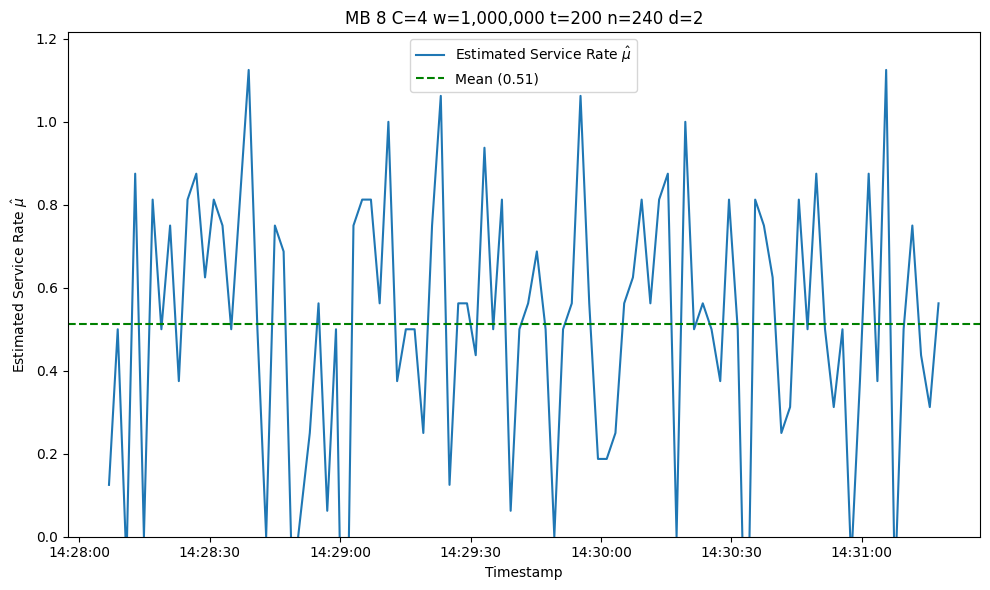

In [49]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=16 $\lambda=4.0$

In [50]:
MB=16
C=4
w=1_000_000
t=200
n=240
d=2

In [51]:
lam = get_lam(C, w)

In [52]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_05Dec/round_trips_MB_16_C4_w1000000_t200_n240_d2_1.csv', 'data_05Dec/round_trips_MB_16_C4_w1000000_t200_n240_d2_2.csv', 'data_05Dec/round_trips_MB_16_C4_w1000000_t200_n240_d2_3.csv', 'data_05Dec/round_trips_MB_16_C4_w1000000_t200_n240_d2_4.csv']
Reading from data_05Dec/queue_size_MB_16_C4_w1000000_t200_n240_d2.csv


In [53]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-05 14:33:13.756,2024-12-05 14:33:13.756,0.0,1.0,1.0,1.0
2024-12-05 14:33:15.764,2024-12-05 14:33:15.764,0.0,4.0,2.0,4.0
2024-12-05 14:33:17.772,2024-12-05 14:33:17.772,0.0,8.0,3.0,8.0
2024-12-05 14:33:19.781,2024-12-05 14:33:19.781,0.0,13.0,6.0,13.0
2024-12-05 14:33:21.789,2024-12-05 14:33:21.789,0.0,7.0,5.0,7.0


In [54]:
r_df.head()

,i,start,end,rtt,ok
16,16,2024-12-05 14:33:13.212582827,2024-12-05 14:33:14.642876387,1.430294,0
17,17,2024-12-05 14:33:14.423337221,2024-12-05 14:33:15.615210772,1.191874,0
18,18,2024-12-05 14:33:15.842617750,2024-12-05 14:33:17.795991182,1.953373,0
19,19,2024-12-05 14:33:16.917480946,2024-12-05 14:33:19.056648016,2.139167,0
20,20,2024-12-05 14:33:17.380538940,2024-12-05 14:33:19.773713589,2.393175,0


In [55]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [56]:
cq_df.head()

,time,d,q
time,,,
2024-12-05 14:33:14.158932209,2024-12-05 14:33:14.158932209,-1,3
2024-12-05 14:33:14.319211483,2024-12-05 14:33:14.319211483,-1,2
2024-12-05 14:33:14.421408892,2024-12-05 14:33:14.421408892,1,3
2024-12-05 14:33:14.423337221,2024-12-05 14:33:14.423337221,1,4
2024-12-05 14:33:14.424463511,2024-12-05 14:33:14.424463511,1,5


In [57]:
mu_hat = estimate_mu(q_df, lam, d, MB)

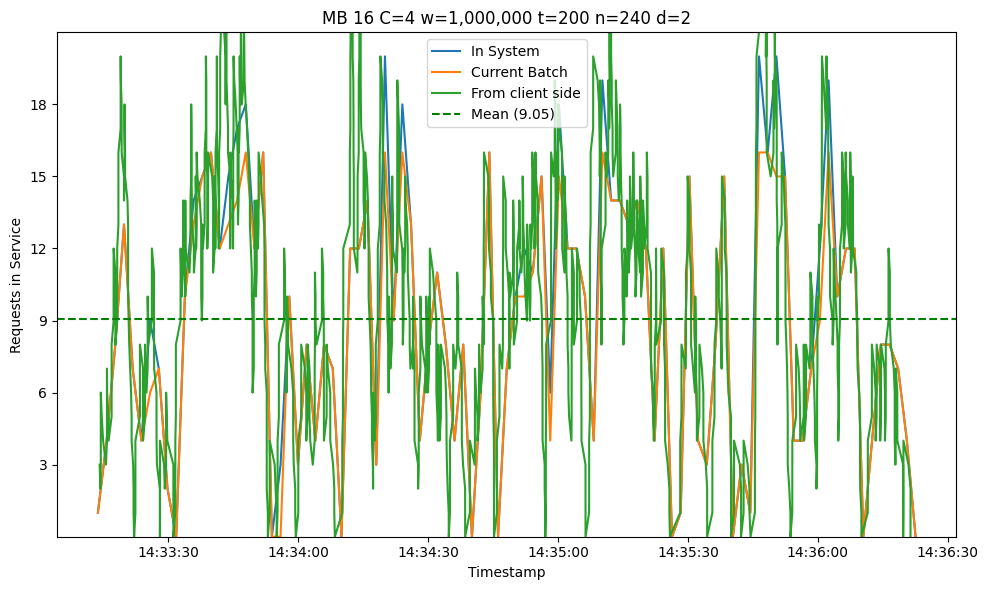

In [58]:
plot_queues(q_df, cq_df, exp_str)

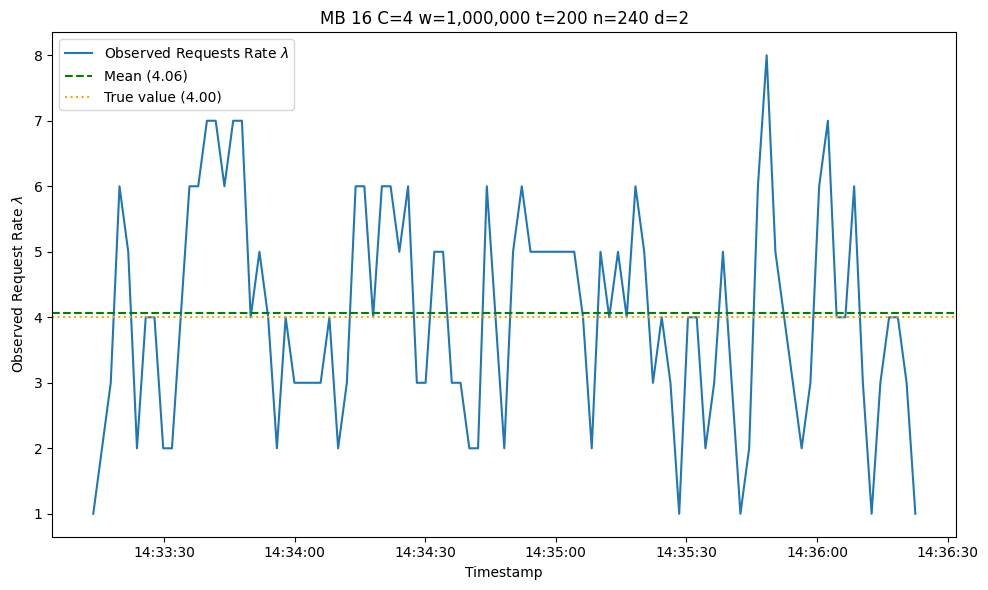

In [59]:
plot_input_rate(q_df, lam, exp_str)

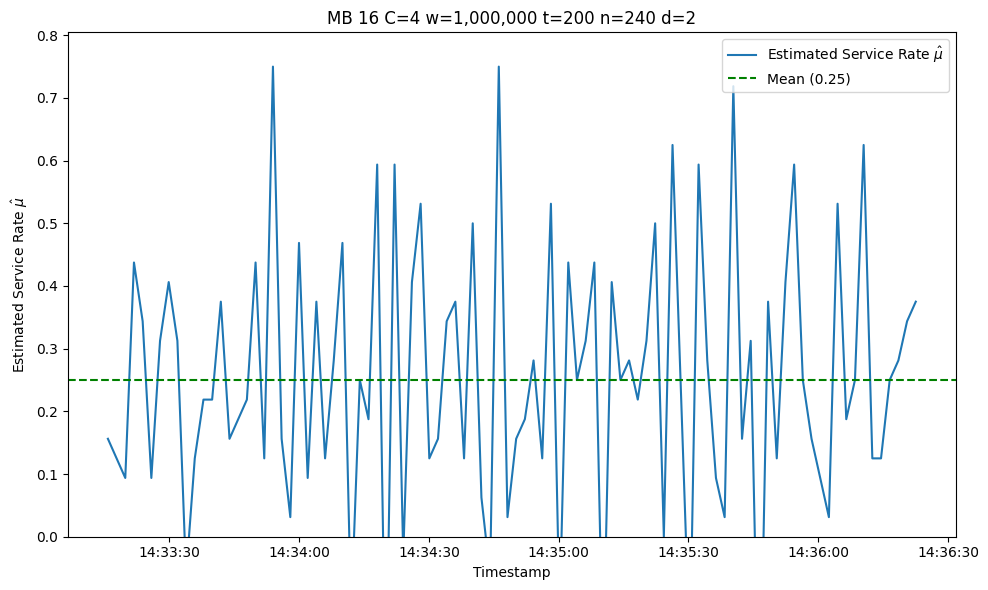

In [60]:
plot_estimated_mu(mu_hat, r_df, exp_str)